In [1]:
import os
import pandas as pd
import notebook_utils.notebook_helpers as utils
from cuopt_sh_client import CuOptServiceSelfHostClient

# Daily Deliveries
## Capacitated Vehicle Routing Problem (CVRP)

Micro fulfillment centers allow retailers to move predictable, high volume products closer to the end consumer allowing for lower costs and shorter overall delivery times.

In this scenario we have a number of same-day delivery orders that we would like to process for a given area from a given micro fulfillment center. We have the requisite number of delivery vehicles and enough time to deliver all packages over the course of a single day. Each delivery vehicle has a maximum capacity of orders  it can carry and we are looking for the route assignment that minimizes the total distance driven by all vehicles.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 MFC 
        - demand: [0]
    - 7 Delivery Locations
        - demand: [4, 4, 2, 2, 1, 2, 1]
    

- 3 Delivery vehicles each with an associated capacity
    - 2 trucks
        - capacity: [8, 8]
    - 1 van
        - capacity: [4]
        

Below we visualize the delivery locations with respect to the MFC.  The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_creation.ipynb](cost_matrix_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

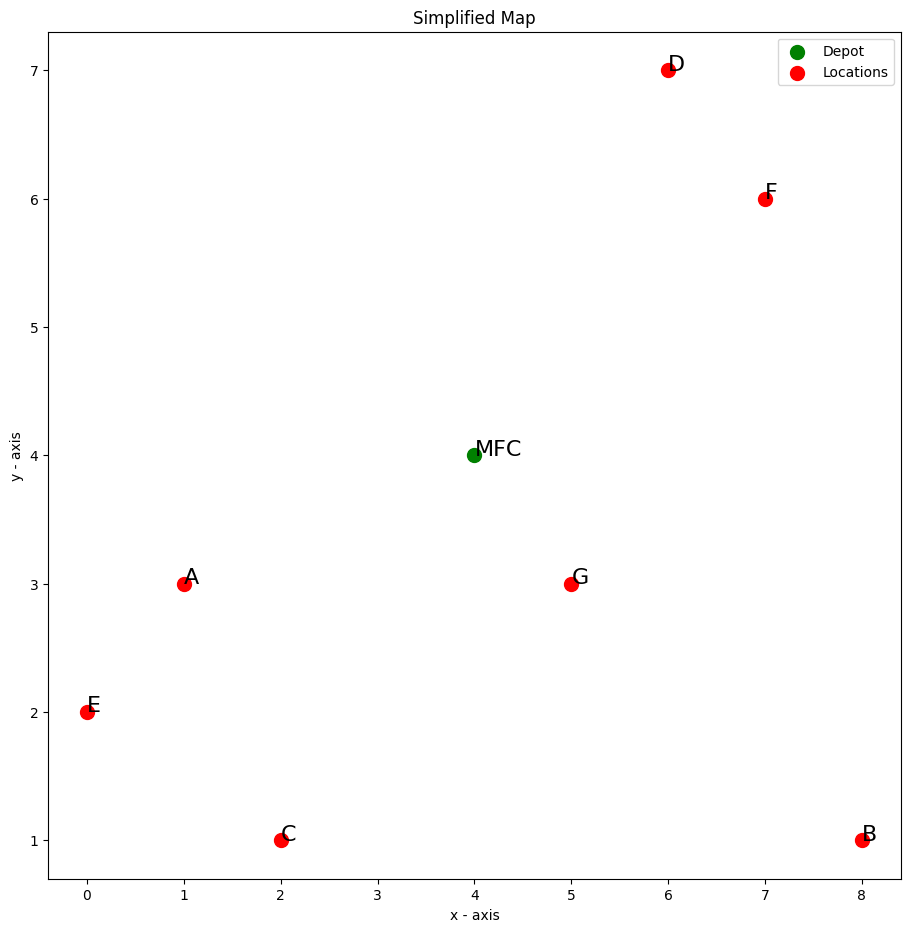

In [2]:
location_names       = [ "MFC",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [ [4, 4],    [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
utils.gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we simply use distance as our cost.

Here is the cost(distance) matrix corresponding to the above locations:

In [3]:
distance_matrix = [
    [0.0, 3.1, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4],
    [3.1, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0],
    [5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6],
    [3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6],
    [3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1],
    [4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1],
    [3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6],
    [1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]
]

distance_matrix

[[0.0, 3.1, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4],
 [3.1, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0],
 [5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6],
 [3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6],
 [3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1],
 [4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1],
 [3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6],
 [1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]]

 ### Demand and Capacity

Set up the demand for each location and the capacity for each vehicle

In [4]:
location_ids = [i+1 for i in range(len(location_names)-1)] # exclude the fulfillment center from task data
#                  "A"    "B"    "C"    "D"     "E"     "F"     "G"
location_demand = [ 4,     4,     2,     2,      1,      2,      1]
#                    Vehicle 0     Vehicle 1     Vehicle 2
vehicle_capacity = [    8,             8,            4     ]
#                   Vehicle 0 loc, Vehicel 1 loc, Vehicle 2 loc
vehicle_locs     = [  [0, 0 ],       [0, 0],        [0, 0] ]
n_vehicles       = len(vehicle_locs)

# Initialize cuOpt Service Client and cuOpt Problem Data

In [5]:
ip = "0.0.0.0"
port = 5000

client = CuOptServiceSelfHostClient(
    ip=ip,
    port=port
)

cuopt_problem_data = {}

### Set Cost Matrix

Dispatch cost matrix to the server

In [6]:
cuopt_problem_data["cost_matrix_data"] = {
        "data": {
            "0": distance_matrix
        }
    }

### Set Task Data

Dispatch task data to the server

In [7]:
cuopt_problem_data["task_data"] = {
        "task_locations": location_ids,
        "demand": [location_demand],
    }

### Set Vehicle Data

Dispatch vehicle data to the server

In [8]:
cuopt_problem_data["fleet_data"] = {
        "vehicle_locations": vehicle_locs,
        "capacities": [vehicle_capacity],
    }

### Set Solver Settings


Dispatch solver settings to the server

In [9]:
cuopt_problem_data["solver_config"] = {
        "time_limit": 5
    }

### Get Optimized Routes

In [10]:
# Solve the problem
solver_response = client.get_optimized_routes(
    cuopt_problem_data
)

# Process returned data
solver_resp = solver_response["response"]["solver_response"]

if solver_resp["status"] == 0:
    print("Cost for the routing in distance: ", solver_resp["solution_cost"])
    print("Vehicle count to complete routing: ", solver_resp["num_vehicles"])
    utils.show_vehicle_routes(solver_resp, location_names)
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", solver_resp["status"])

2024-12-13 20:13:20.796 notebook_utils.cuopt_self_host_client WARNING Client version missing or not the current format. Please upgrade your cuOpt client to '24.11', or set the client version to 'custom' if this is a custom client.


Cost for the routing in distance:  26.799999594688416
Vehicle count to complete routing:  2
For vehicle - 0 route is: 

MFC->A->E->C->G->MFC


For vehicle - 1 route is: 

MFC->B->F->D->MFC




In [ ]:
vehicle_colors = ["red", "green", "blue"]
utils.map_vehicle_routes(location_coordinates_df, solver_resp, vehicle_colors).show()

### Additional Constraints 
##### Minimum Vehicles

cuOpt has found a solution that does not require all available vehicles because the combined capacity of the two larger vehicles (16) is equal to total location demand (16).  In some cases, this is a great solution as it gives the option to save on the costs associated with additional vehicles.  In other cases there is value to assigning all available resources.  In the latter case we can require that cuOpt use all 3 available vehicles and re-solve the problem with this constraint.

**Update the existing solver configuration in server and re-optimize**

In [ ]:
# Set the minimum vehicles on the fleet data
cuopt_problem_data["fleet_data"]["min_vehicles"] = n_vehicles

In [ ]:
# Re-Solve the problem
solver_response = client.get_optimized_routes(
    cuopt_problem_data
)

# Process returned data
solver_resp = solver_response["response"]["solver_response"]

if solver_resp["status"] == 0:
    print("Cost for the routing in distance: ", solver_resp["solution_cost"])
    print("Vehicle count to complete routing: ", solver_resp["num_vehicles"])
    utils.show_vehicle_routes(solver_resp, location_names)
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", solver_resp["status"])

In [ ]:
utils.map_vehicle_routes(location_coordinates_df, solver_resp, vehicle_colors).show()


SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.